In [36]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df=pd.read_csv('topics.csv', on_bad_lines='skip')

In [38]:
df.shape

(18775, 2)

In [39]:
df.head(10)

,text,label
0,"Y'all lighten up on Harry, Skip'll be like tha...",rec.sport.baseball
1,\nIt depends on the cause of the pneumonia. F...,sci.med
2,\nThere is a wonderful book by Jean Meeus call...,sci.space
3,"\n\n\nNo, you have completely misunderstood. ...",talk.politics.mideast
4,\nThat's not true. I gave you two examples....,alt.atheism
5,\nAbout a month ago there was a photo posted o...,sci.electronics
6,Thanks to all those people who recommended Wor...,comp.os.ms-windows.misc
7,\nYou are making precisely one of the points I...,sci.med
8,\n\tDoes anyone have details on this? What s...,comp.sys.mac.hardware
9,"While there are too many PS clones to count, s...",comp.os.ms-windows.misc


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18775 entries, 0 to 18774
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18396 non-null  object
 1   label   18748 non-null  object
dtypes: object(2)
memory usage: 293.5+ KB


In [41]:
df=df.dropna(how='any')
df=df.drop_duplicates()

In [42]:
df['label'].value_counts()

label
soc.religion.christian                                                                                                                                                                                                                                                                                                                                                                                                                                 978
rec.sport.hockey                                                                                                                                                                                                                                                                                                                                                                                                                                       978
rec.motorcycles                                                                                             

In [43]:
df=df[df['label'].str.startswith(('soc.','rec.','comp.','sci.','misc.','talk.','alt.'))]

In [44]:
df['label'].value_counts()

label
rec.sport.hockey            978
soc.religion.christian      978
rec.motorcycles             971
comp.sys.ibm.pc.hardware    967
sci.crypt                   964
rec.sport.baseball          962
sci.med                     962
comp.windows.x              958
sci.space                   955
comp.graphics               954
sci.electronics             954
comp.os.ms-windows.misc     949
misc.forsale                945
rec.autos                   937
comp.sys.mac.hardware       931
talk.politics.mideast       911
talk.politics.guns          887
alt.atheism                 769
talk.politics.misc          711
talk.religion.misc          598
Name: count, dtype: int64

In [45]:
df.shape

(18241, 2)

In [46]:
df.nunique()

text     18176
label       20
dtype: int64

In [47]:
df=df.drop_duplicates(subset='text')

In [48]:
mapping = {
    "rec.sport.hockey": "Sports",
    "rec.sport.baseball": "Sports",
    "rec.motorcycles": "Sports",
    "rec.autos": "Sports",

    "soc.religion.christian": "Religion",
    "talk.religion.misc": "Religion",
    "alt.atheism": "Religion",

    "comp.os.ms-windows.misc": "Computer-Software",
    "comp.windows.x": "Computer-Software",
    "comp.graphics": "Computer-Software",

    "comp.sys.ibm.pc.hardware": "Computer-Hardware",
    "comp.sys.mac.hardware": "Computer-Hardware",

    "sci.crypt": "Science",
    "sci.med": "Science",
    "sci.space": "Science",
    "sci.electronics": "Science",

    "talk.politics.mideast": "Politics",
    "talk.politics.guns": "Politics",
    "talk.politics.misc": "Politics",

    "misc.forsale": "Miscellaneous"
}

In [49]:
df["new_label"] = df["label"].map(lambda x: mapping.get(x, "Uncategorized"))
df['label']=df['new_label']

In [50]:
import re
import nltk
nltk.download('stopwords', download_dir=r"C:\Users\HP\nltk_data")
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\HP\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
def clean_text(text):
    text=re.sub(r'(?im)^(from|date|message-id|sender|organization|expires|reply-to|distribution|keywords|newsgroups|references|lines)[:\-].*$','',text)
    text = re.sub(r'http[s]?://\S+|www\.\S+', ' ', text)
    text=re.sub(r'\S+@\S+',' ',text)
    text= re.sub(r'[^a-zA-Z]'," ",text)
    text=text.lower()
    text=re.sub(r'\s+'," ",text)
    text=' '.join([word for word in text.split() if len(word)>2])
    text=' '.join([word for word in text.split() if word not in stop_words])

    return text
    

In [52]:
df['text']=df['text'].apply(clean_text)
df=df[df['text'].str.strip() != '']

In [53]:
from collections import Counter

In [54]:
all_texts=' '.join(df['text'])
words=all_texts.split()
words_counter= Counter(words)
"""remove_words = {word for word, count in words_counter.items() if count > 3561}
def remove_frequent_words(text, remove_words):
    return ' '.join([word for word in text.split() if word not in remove_words])

df['text'] = df['text'].apply(lambda x: remove_frequent_words(x, remove_words))
all_texts=' '.join(df['text'])
words=all_texts.split()
words_counter= Counter(words)"""
top_20_words=words_counter.most_common(20)
print("Top 20 most occurring words:")
for word, count in top_20_words:
    print(word,": ",count)

Top 20 most occurring words:
one :  10255
would :  10071
like :  6458
people :  6333
get :  5809
know :  5710
also :  5537
use :  4975
think :  4928
time :  4829
max :  4365
could :  4148
new :  4033
well :  4020
may :  3948
good :  3852
even :  3745
two :  3588
see :  3576
first :  3561


In [55]:
all_text = ' '.join(df['text'].astype(str))
words = all_text.split()
unique_words = set(words)
print("Number of unique words:", len(unique_words))

Number of unique words: 83963


In [56]:
df.shape

(18121, 3)

#### Logistic regression

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [58]:
X_train, X_test, y_train, y_test=train_test_split(df['text'],df['label'],test_size=0.2,random_state=42,stratify=df['label'])

In [59]:
vectorizer=TfidfVectorizer()
X_train_vec=vectorizer.fit_transform(X_train)
X_test_vec=vectorizer.transform(X_test)

In [60]:
model=LogisticRegression(max_iter=1000)
model.fit(X_train_vec,y_train)

LogisticRegression(max_iter=1000)

In [61]:
y_pred=model.predict(X_test_vec)
print(classification_report(y_test,y_pred))

                   precision    recall  f1-score   support

Computer-Hardware       0.83      0.75      0.79       377
Computer-Software       0.87      0.86      0.87       568
    Miscellaneous       0.85      0.64      0.73       188
         Politics       0.84      0.78      0.81       499
         Religion       0.90      0.79      0.84       467
          Science       0.78      0.87      0.82       763
           Sports       0.83      0.92      0.87       763

         accuracy                           0.83      3625
        macro avg       0.84      0.80      0.82      3625
     weighted avg       0.84      0.83      0.83      3625



#### Naive Bayes

In [62]:
from sklearn.naive_bayes import MultinomialNB

In [63]:
model= MultinomialNB()
model.fit(X_train_vec,y_train)

MultinomialNB()

In [64]:
y_pred=model.predict(X_test_vec)
print(classification_report(y_test,y_pred))

                   precision    recall  f1-score   support

Computer-Hardware       0.84      0.48      0.61       377
Computer-Software       0.82      0.85      0.83       568
    Miscellaneous       0.92      0.06      0.12       188
         Politics       0.87      0.71      0.78       499
         Religion       0.94      0.73      0.82       467
          Science       0.61      0.94      0.74       763
           Sports       0.82      0.94      0.87       763

         accuracy                           0.77      3625
        macro avg       0.83      0.67      0.68      3625
     weighted avg       0.81      0.77      0.75      3625



#### ANN:

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [66]:
le= LabelEncoder()
df['encoded_label']=le.fit_transform(df['label'])
y=to_categorical(df['encoded_label'])

In [67]:
max_features=30000
vectorizer_ann=TfidfVectorizer(
    max_features=max_features,
    ngram_range=(1,3),
    min_df=2)
X_tfidf=vectorizer_ann.fit_transform(df['text']).toarray()
X=X_tfidf

In [68]:
X_train1, X_test, y_train1, y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=df['encoded_label'])
X_train, X_val, y_train, y_val= train_test_split(X_train1,y_train1,test_size=0.1,random_state=42,stratify=y_train1)

In [69]:
def build_ann(input_dim: int, num_classes: int) -> keras.Model:
        inputs = keras.Input(shape=(input_dim,), name="tfidf_or_svd_input")
        x = layers.Dense(512, activation="relu")(inputs)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(128, activation="relu")(x)
        outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

        model = keras.Model(inputs, outputs, name="topics_ann")
        opt = keras.optimizers.Adam(learning_rate=1e-3)  # loss scaling handled automatically
        model.compile(optimizer=opt,
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        return model

model = build_ann(input_dim=X_train.shape[1], num_classes=7)

In [70]:
model.summary()

Model: "topics_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfidf_or_svd_input (InputLayer) │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    15,360,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,525,639 (59.23 MB)

 Trainable params: 15,525,639 (59.23 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [72]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(13046, 30000)
(13046, 7)
(1450, 30000)
(1450, 7)


In [77]:
history=model.fit(
    X_train,y_train,
    validation_data=(X_val,y_val),
    epochs=30,
    batch_size=128,
    verbose=2)

Epoch 1/30
102/102 - 57s - 556ms/step - accuracy: 0.9982 - loss: 0.0053 - val_accuracy: 0.7938 - val_loss: 1.2586
Epoch 2/30
102/102 - 57s - 561ms/step - accuracy: 0.9986 - loss: 0.0035 - val_accuracy: 0.8021 - val_loss: 1.2983
Epoch 3/30
102/102 - 50s - 494ms/step - accuracy: 0.9990 - loss: 0.0027 - val_accuracy: 0.8014 - val_loss: 1.3213
Epoch 4/30
102/102 - 81s - 796ms/step - accuracy: 0.9986 - loss: 0.0029 - val_accuracy: 0.8048 - val_loss: 1.3515
Epoch 5/30
102/102 - 80s - 782ms/step - accuracy: 0.9988 - loss: 0.0028 - val_accuracy: 0.8007 - val_loss: 1.3762
Epoch 6/30
102/102 - 60s - 591ms/step - accuracy: 0.9989 - loss: 0.0027 - val_accuracy: 0.7993 - val_loss: 1.3753
Epoch 7/30
102/102 - 41s - 401ms/step - accuracy: 0.9986 - loss: 0.0035 - val_accuracy: 0.8034 - val_loss: 1.3495
Epoch 8/30
102/102 - 25s - 242ms/step - accuracy: 0.9986 - loss: 0.0029 - val_accuracy: 0.8021 - val_loss: 1.3802
Epoch 9/30
102/102 - 34s - 334ms/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 

In [78]:
results=model.evaluate(X_test,y_test,verbose=1)
print('Test loss:',results[0])
print('Test accuracy;',results[1])


114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8054 - loss: 1.4198
Test loss: 1.4460934400558472
Test accuracy; 0.810758650302887


In [79]:
y_pred_prob=model.predict(X_test)
y_pred=np.argmax(y_pred_prob,axis=1)
y_test_labels = np.argmax(y_test, axis=1)
labels_names=le.classes_
print(classification_report(y_test_labels, y_pred, target_names=labels_names))

114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
                   precision    recall  f1-score   support

Computer-Hardware       0.74      0.77      0.75       377
Computer-Software       0.82      0.84      0.83       568
    Miscellaneous       0.80      0.74      0.77       188
         Politics       0.83      0.75      0.79       499
         Religion       0.84      0.81      0.83       467
          Science       0.79      0.79      0.79       763
           Sports       0.83      0.89      0.86       763

         accuracy                           0.81      3625
        macro avg       0.81      0.80      0.80      3625
     weighted avg       0.81      0.81      0.81      3625



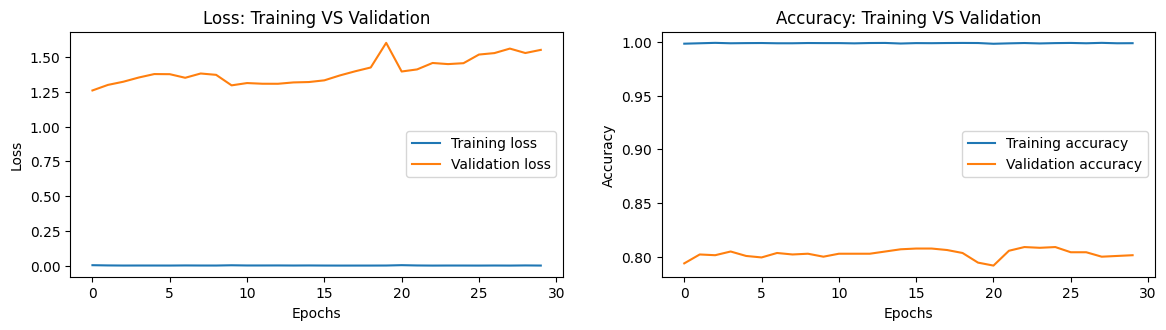

In [80]:
plt.figure(figsize=(14,7))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss: Training VS Validation')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy: Training VS Validation')
plt.legend()

plt.show()